In [1]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re
import os.path
import os

interesting_keys = ['episode_reward_mean', "episode_len_mean", 'episodes_total', 'custom_metrics/inv', "time_this_iter_s", 'custom_metrics/accept']
hist_keys = ["inv", "accept"]


def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 0}
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    events = ea.Scalars("ray/tune/episode_reward_mean")
    ids = [x.step for x in events]
    ids_s = set(x.step for x in events)
    df['step'] = ids
    walltimes = [x.wall_time for x in events]
    df['walltime'] = walltimes
    df['totalwalltime'] = walltimes[-1] - walltimes[0]
    df.set_index('step', inplace=True)
    for tag in hist_keys:
        fulltag = 'ray/tune/hist_stats/' + tag
        events = ea.Histograms(fulltag)
        indexes = [x.step for x in events if x.step in ids_s]
        mins = [x.histogram_value.min
                for x in events if x.step in ids_s]
        maxs = [x.histogram_value.max 
                for x in events if x.step in ids_s]
        means = [x.histogram_value.sum / x.histogram_value.num 
                 for x in events if x.step in ids_s]
        variances = [np.max((0, x.histogram_value.sum_squares / x.histogram_value.num - (x.histogram_value.sum / x.histogram_value.num)**2))
                     for x, mean in zip(events, means) if x.step in ids_s]
        stds = np.sqrt(variances)
        #print(events[-1].histogram_value)
        df.loc[indexes, tag+"_max"] = maxs
        df.loc[indexes, tag+"_min"] = mins
        df.loc[indexes, tag+"_mean"] = means
        df.loc[indexes, tag+"_std"] = stds
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        success = False
        for i in range(3):
            try:
                events = ea.Scalars(fultag)
            except KeyError:
                fultag+= "_mean"
            else:
                success = True
                break
        if not success:
            raise KeyError(fultag)

        scalars = np.array([x.value for x in events if x.step in ids_s])
        indexes = np.array([x.step for x in events if x.step in ids_s])
        df.loc[indexes, tag] = scalars

    df.reset_index(inplace=True)
    return df


def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

In [38]:
nepisodes=200000
mainpath = f'logs/paperrun2/e{nepisodes}/cmafixed/**/*tfevents*'
first, _ = mainpath.split("**")

shortname = ''.join(removeprefix(first, 'logs/').split('/'))
print(shortname)

figdir = "figures/" + shortname + "/"
os.makedirs(figdir, exist_ok=True)

paperrun2e200000cmafixed


In [39]:
fuldfs = []
runid = 0
forcereload = False

if not forcereload and os.path.exists(first + "/sumup.df.pkl"):
    alldf = pd.read_pickle(first + "/sumup.df.pkl")
else:
    for path in tqdm.tqdm(glob(mainpath, recursive=True)):
        try:
            curdf = create_df(path)
        except Exception as e:
            print(path)
            print(type(e), e)
        else:
            curdf['run'] = runid
            curdf['badsiteprob'] = float(re.search("good_site_prob=(.+),", path).group(1))
            curdf['trial_id'] = re.search(r"partner_choice_(.+)_(?:\d+)_good", path).group(1)
            fuldfs.append(curdf)
            runid += 1
    alldf = pd.concat(fuldfs)
    first, _ = mainpath.split("**")
    binsize = 1000
    mode = "ppo"
    if "cma" in mainpath: 
        mode = "cma"
    else:
        mode = "ppo"
    ps = [1, 0.5, 0.2, 0.1]
    if "true_episode_reward_mean" not in alldf.columns:
        alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
    if mode == "ppo": 
        alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
    if "p" not in alldf.columns:
        alldf["p"] = alldf["badsiteprob"]


    alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
    alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
    alldf = alldf.query("p in @ps").copy()
    alldf.to_pickle(first + "/sumup.df.pkl")


In [40]:
figwidth = 3.3

In [41]:
binsize = nepisodes//200
stepbin = alldf["step"].max() // 300
print(binsize)
print(stepbin)

if "cma" in mainpath: 
    mode = "cma"
else:
    mode = "ppo"
ps = [1, 0.5, 0.2, 0.1]
alldf = alldf.query("p in @ps").copy()

if "true_episode_reward_mean" not in alldf.columns:
    alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
if mode == "ppo": 
    alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
if "p" not in alldf.columns:
    alldf["p"] = alldf["badsiteprob"]


alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
alldf.to_pickle(first + "/sumup.df.pkl")

1000
494417


In [42]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figsize=(figwidth, figwidth/1.5)

In [43]:
alldf

,step,walltime,totalwalltime,inv_max,inv_min,inv_mean,inv_std,accept_max,accept_min,accept_mean,...,custom_metrics/inv,time_this_iter_s,custom_metrics/accept,run,badsiteprob,trial_id,true_episode_reward_mean,p,episode_bin_right,step_bin_right
0,196630,1.607987e+09,151785.163402,0.886999,0.886999,0.886999,0.0,0.5,0.0,0.001898,...,0.886999,234.092026,0.001898,0,0.1,c6304_00011,6.541610,0.1,1000.0,197000
1,215624,1.607987e+09,151785.163402,7.566971,7.566971,7.566971,0.0,7.5,2.0,4.750000,...,7.566971,23.776958,4.750000,0,0.1,c6304_00011,32.955330,0.1,1000.0,216000
2,227336,1.607987e+09,151785.163402,10.515092,10.515092,10.515092,0.0,9.5,0.0,0.537500,...,10.515093,14.561344,0.537500,0,0.1,c6304_00011,29.541882,0.1,1000.0,228000
3,230340,1.607987e+09,151785.163402,9.496546,9.496546,9.496546,0.0,9.0,0.0,0.238220,...,9.496544,4.528208,0.238220,0,0.1,c6304_00011,25.140537,0.1,1000.0,231000
4,263030,1.607987e+09,151785.163402,7.702010,7.702010,7.702010,0.0,7.5,1.0,4.200000,...,7.702011,39.343987,4.200000,0,0.1,c6304_00011,29.849571,0.1,1000.0,264000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,27530440,1.608019e+09,32692.951035,8.500000,8.500000,8.500000,0.0,8.5,8.5,8.500000,...,8.500000,10.763367,8.500000,95,0.5,c3f54_00001,48.875000,0.5,200000.0,27531000
1996,27542900,1.608019e+09,32692.951035,8.500000,8.500000,8.500000,0.0,8.5,8.5,8.500000,...,8.500000,10.999958,8.500000,95,0.5,c3f54_00001,39.099998,0.5,200000.0,27543000
1997,27555054,1.608019e+09,32692.951035,8.500000,8.500000,8.500000,0.0,8.5,8.5,8.500000,...,8.500000,9.180006,8.500000,95,0.5,c3f54_00001,48.875000,0.5,200000.0,27556000
1998,27567682,1.608019e+09,32692.951035,8.500000,8.500000,8.500000,0.0,8.5,8.5,8.500000,...,8.500000,9.476994,8.500000,95,0.5,c3f54_00001,43.987499,0.5,200000.0,27568000


In [44]:
from pandas.api.types import CategoricalDtype
ps = [1, 0.5, 0.2, 0.1]
step = False
epcollapsed = alldf.groupby(["p", "run", "episode_bin_right"], as_index=False).mean()
print("ep done")
if step:
    stepcollapsed = alldf[["p", "run", "step_bin_right", "inv_mean", "inv_std", "accept_mean"]].groupby(["p", "run", "step_bin_right"], as_index=False).mean()
    stepcollapsed["p"] = stepcollapsed["p"].astype(pcat)

print("step done")
pcat = CategoricalDtype(ps, ordered=True)
epcollapsed["p"] = epcollapsed["p"].astype(pcat)
print("p as cat done")
alldf["p"] = alldf["p"].astype(pcat)

ep done
step done
p as cat done


In [45]:
print("ok")
print(alldf.query("episode_bin_right >= @nepisodes").groupby("p")["run"].nunique())

ok
p
1.0    24
0.5    24
0.2    24
0.1    24
Name: run, dtype: int64


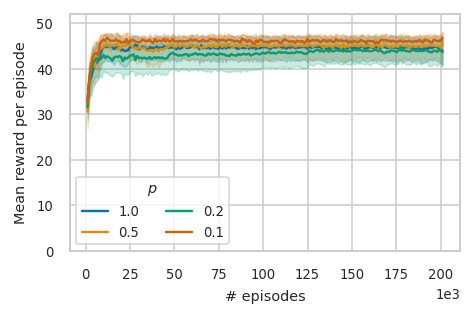

In [46]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
#sns.lineplot(
#    data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p",
#    estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
#)

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p", ax=ax)

ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.ylim(0, 52)
plt.ylabel('Mean reward per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
plt.tight_layout()
plt.savefig(figdir + "reward_mean_synth.pdf")

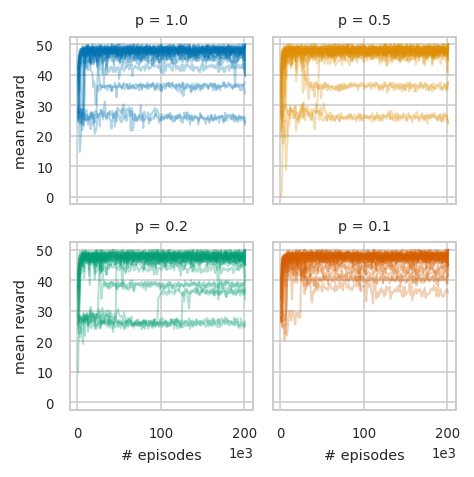

In [47]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/2), aspect=1, hue="p", despine=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean',
        estimator=None, alpha=0.3, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "mean reward")
g.tight_layout()
g.savefig(figdir + "reward_mean_detail.pdf")

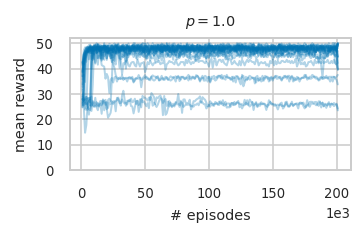

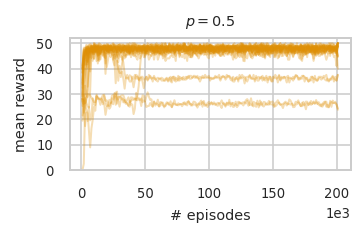

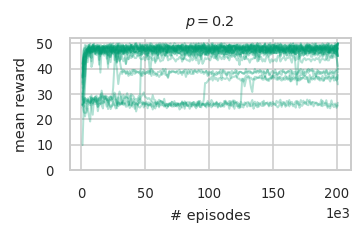

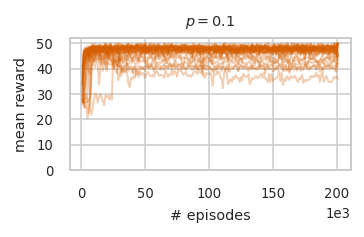

In [48]:
for i, (name, group) in enumerate(epcollapsed.groupby("p")):
    fig = plt.figure(figsize=(figwidth/1.3, figwidth/2))
    ax = fig.gca()
    sns.lineplot(data=group, x="episode_bin_right", y="episode_reward_mean", estimator=None, units="run", alpha=0.3, linewidth=1, color=sns.color_palette()[i])
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylabel("mean reward")
    ax.set_xlabel("# episodes")
    ax.set_title(f"$p = {name}$")
    ax.set_ylim(0, 52)
    ax.set_yticks([i for i in range(0, 51, 10)])
    fig.tight_layout()
    fig.savefig(figdir + f"reward_mean_detail_p{name}.pdf")
    plt.show(fig)

In [36]:
if step:
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    sns.lineplot(
            data=stepcollapsed, x="step_bin_right", y='episode_reward_mean', hue="p",
            estimator=None, linewidth=1, ax=ax, units="run"
        )
    ax.ticklabel_format(axis="x", scilimits=(6, 6))

    plt.ylim(0, 50)
    plt.ylabel('mean reward per episode')
    plt.xlabel('# step')
    plt.legend(ncol=2, title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "reward_mean_synth_step.pdf")

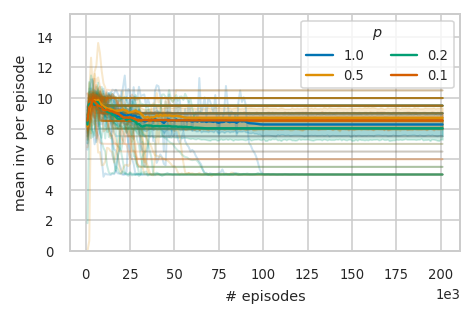

In [46]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p", ax=ax)

plt.ylim(0, 15.5)
plt.ylabel('mean inv per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "inv_mean_synth.pdf")

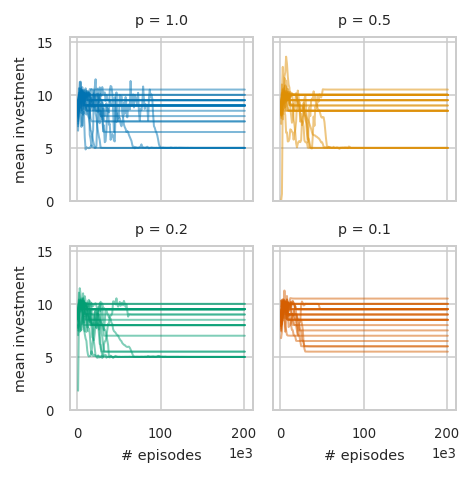

In [47]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/2, aspect=1, sharex=True, hue="p", despine=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv',
        estimator=None, alpha=0.5, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylim(0, 15.5)
g.set_axis_labels("# episodes", "mean investment")
g.tight_layout()
g.savefig(figdir + "inv_mean_details.pdf")

In [48]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/inv', hue="badsiteprob", units="run", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean inv per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "inv_mean_synth_step.pdf")

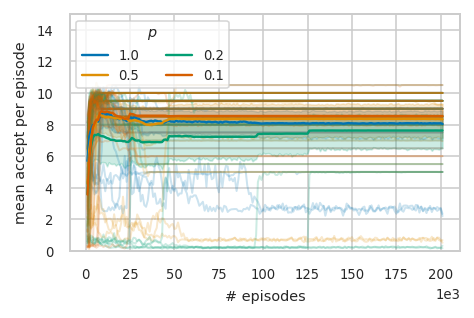

In [49]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p", ax=ax)


plt.ylim(0, 15)
plt.ylabel('mean accept per episode')
plt.xlabel('# episodes')
plt.legend(title="$p$", ncol=2)
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "accept_mean_synth.pdf")

In [50]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/accept', hue="p", units="run", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean accept per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "accept_mean_step.pdf")

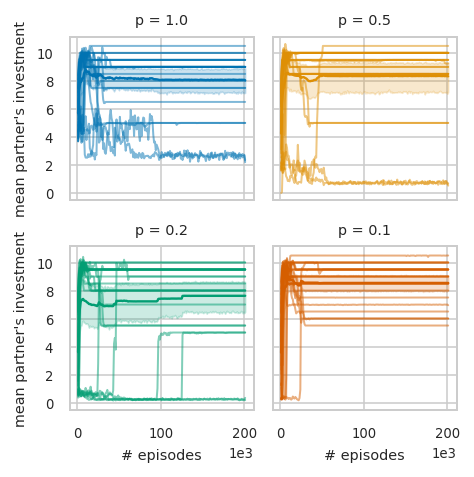

In [51]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "mean partner's investment")
g.tight_layout()

plt.savefig(figdir + "accept_mean_detail.pdf")

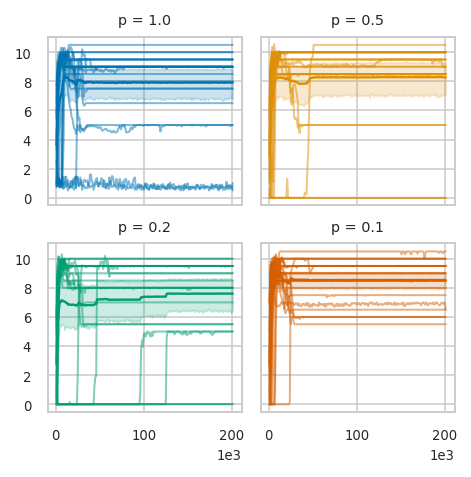

In [52]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
plt.savefig(figdir + "accept_min_detail.pdf")

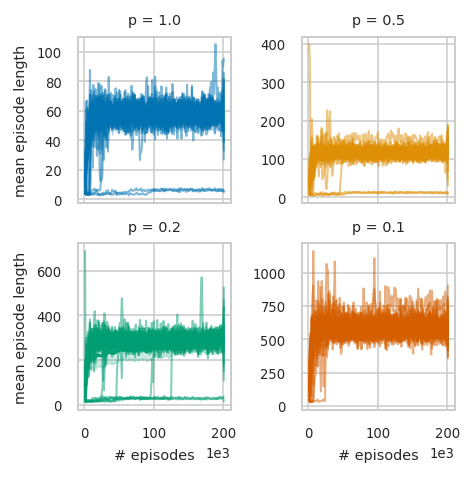

In [53]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/(1*2)), aspect=1, sharey=False, hue="p", despine=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run", )
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "mean episode length")
g.tight_layout()

plt.savefig(figdir + "episode_mean_detail.pdf")

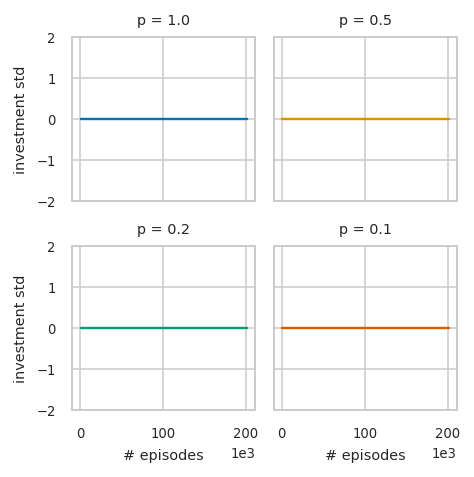

In [54]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p", despine=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set(ylim=(-2, 2))
g.set_axis_labels("# episodes", "investment std")
g.tight_layout()

plt.savefig(figdir + "inv_std_detail.pdf")

In [49]:
outalldf = pd.read_pickle("logs/paperrun2/e200000/ppobiglr/sumup.df.pkl")
out = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])
outalldf = pd.read_pickle("logs/paperrun2/e200000/cmafixed/sumup.df.pkl")
outcma = outalldf.groupby(["p", "run"], as_index=False).apply(lambda x: x[x.step == x.step.max()])

In [50]:
out["timeperit"] = out["totalwalltime"] / out["step"]
outcma["timeperit"] = outcma["totalwalltime"] / outcma["step"]

In [51]:
out[["p", "run", "step", "totalwalltime", "timeperit"]]

,,p,run,step,totalwalltime,timeperit
0,1974,0.1,0,12640000,14822.430908,0.001173
1,2404,0.1,1,15392000,205505.995161,0.013351
2,2402,0.1,2,15379200,23049.085284,0.001499
3,2730,0.1,3,17484800,187798.503975,0.010741
4,2406,0.1,4,15404800,20648.587331,0.001340
...,...,...,...,...,...,...
91,571,1.0,81,3660800,5139.660191,0.001404
92,576,1.0,87,3692800,39927.193020,0.010812
93,583,1.0,88,3737600,2932.487403,0.000785
94,567,1.0,90,3635200,4485.902268,0.001234


In [52]:
outcma[["p", "run", "step", "totalwalltime", "timeperit"]]

,,p,run,step,totalwalltime,timeperit
0,1999,0.1,0,124575948,151785.163402,0.001218
1,1999,0.1,1,126480554,154737.131274,0.001223
2,1999,0.1,2,148325274,170382.527705,0.001149
3,1999,0.1,3,137882558,163437.483320,0.001185
4,1999,0.1,4,135242376,160620.262085,0.001188
...,...,...,...,...,...,...
91,1999,1.0,67,1035894,2167.217888,0.002092
92,1999,1.0,68,12795680,15904.359900,0.001243
93,1999,1.0,69,13074136,16327.609320,0.001249
94,1999,1.0,70,12981478,16316.919803,0.001257


In [53]:
outcma["Algorithm"] = "CMA-ES"

In [54]:
out["Algorithm"] = "PPO"

In [55]:
outcomb = pd.concat((outcma, out))

Text(0, 0.5, 'Total time (s)')

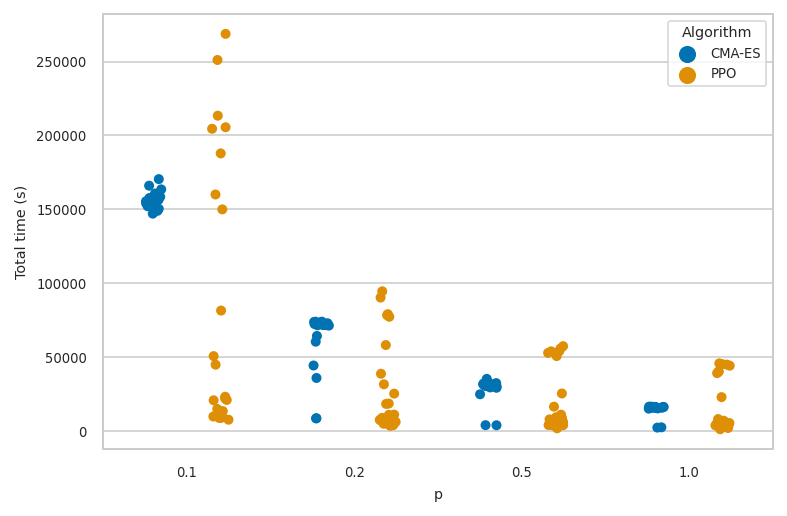

In [56]:
sns.stripplot(data=outcomb, x="p", hue="Algorithm", y="totalwalltime", dodge=True)
plt.ylabel("Total time (s)")

Text(0, 0.5, 'Time per iteration (s)')

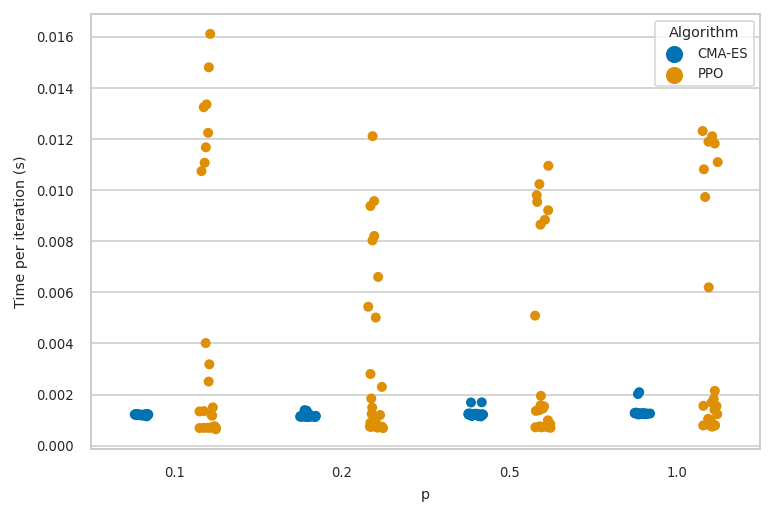

In [57]:
sns.stripplot(data=outcomb, x="p", hue="Algorithm", y="timeperit", dodge = True)
plt.ylabel("Time per iteration (s)")

In [58]:
outcomb.groupby(["Algorithm", "p"]).count()

step  walltime  totalwalltime  inv_max  inv_min  inv_mean  \
Algorithm p                                                                
CMA-ES    0.1    24        24             24       24       24        24   
          0.2    24        24             24       24       24        24   
          0.5    24        24             24       24       24        24   
          1.0    24        24             24       24       24        24   
PPO       0.1    24        24             24       24       24        24   
          0.2    24        24             24       24       24        24   
          0.5    24        24             24       24       24        24   
          1.0    24        24             24       24       24        24   

               inv_std  accept_max  accept_min  accept_mean  ...  \
Algorithm p                                                  ...   
CMA-ES    0.1       24          24          24           24  ...   
          0.2       24          24          24           24  ...   
          0.5       24          24          24           24  ...   
          1.0       24          24          24           24  ...   
PPO       0.1       24          24          24           24  ...   
          0.2       24          24          24           24  ...   
          0.5       24          24          24           24  ...   
          1.0       24          24          24           24  ...   

               custom_metrics/inv  time_this_iter_s  custom_metrics/accept  \
Algorithm p                                                                  
CMA-ES    0.1                  24                24                     24   
          0.2                  24                24                     24   
          0.5                  24                24                     24   
          1.0                  24                24                     24   
PPO       0.1                  24                24                     24   
          0.2                  24                24                     24   
          0.5                  24                24                     24   
          1.0                  24                24                     24   

               run  badsiteprob  trial_id  true_episode_reward_mean  \
Algorithm p                                                           
CMA-ES    0.1   24           24        24                        24   
          0.2   24           24        24                        24   
          0.5   24           24        24                        24   
          1.0   24           24        24                        24   
PPO       0.1   24           24        24                        24   
          0.2   24           24        24                        24   
          0.5   24           24        24                        24   
          1.0   24           24        24                        24   

               episode_bin_right  step_bin_right  timeperit  
Algorithm p                                                  
CMA-ES    0.1                 24              24         24  
          0.2                 24              24         24  
          0.5                 24              24         24  
          1.0                 24              24         24  
PPO       0.1                 24              24         24  
          0.2                 24              24         24  
          0.5                 24              24         24  
          1.0                 24              24         24  

[8 rows x 24 columns]